In [21]:
import numpy as np
import lsst.daf.persistence as dafPersist
import lsst.afw.image.utils as afwImageUtils

from lsst.meas.algorithms.measureCurveOfGrowth import CurveOfGrowth

%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import display

butler = dafPersist.Butler(os.path.join(os.environ["SUPRIME_DATA_DIR"],
                                        "rerun", "price/hsc-1236"))

frame = 1

In [22]:
def splitId(i):
    i = np.array(i)
    oid = i & (2**32 - 1)
    i >>= 32
    ccd = i % 200
    i //= 200
    visit = i
    
    return dict(visit=visit, ccd=ccd, oid=oid)

In [23]:
visit = 1222 if False else 1244
dataId=dict(visit=visit, ccd=44)
cat = butler.get("icSrc", **dataId)
exp = butler.get("calexp", immediate=True, **dataId)

In [24]:
import lsst.afw.display.ds9 as ds9

if False:
    ds9.mtv(exp, frame=frame, title=dataId)

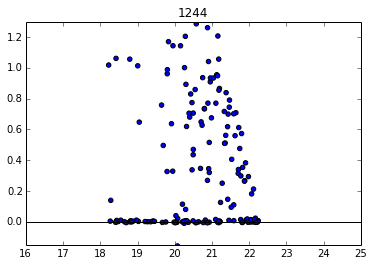

In [25]:
calib = exp.getCalib()
with afwImageUtils.CalibNoThrow():
    psfMag = calib.getMagnitude(cat.getPsfFlux())
    modelMag = calib.getMagnitude(cat.getModelFlux())
good = np.logical_not(cat.get("flags.pixel.saturated.center"))

plt.scatter(modelMag[good], psfMag[good] - modelMag[good])
plt.xlim(16, 25)
plt.ylim(-0.15, 1.3)
plt.title(str(visit))

_ = plt.axhline(0, color='black')

In [26]:
if False:
    import lsst.meas.algorithms.utils as maUtils

    maUtils.showPsfMosaic(exp, frame=2, nx=3)
psf = exp.getPsf()
print '  visit = %d FWHM = %.2f"' % (visit, 2*sqrt(2*np.log(2))*psf.computeShape().getDeterminantRadius()*exp.getWcs().pixelScale().asArcseconds())

  visit = 1244 FWHM = 0.80"


In [ ]:
import lsst.meas.algorithms.measureCurveOfGrowth; lsst.meas.algorithms.measureCurveOfGrowth.fig = None
reload(lsst.meas.algorithms.measureCurveOfGrowth); CurveOfGrowth = lsst.meas.algorithms.measureCurveOfGrowth.CurveOfGrowth

cog = CurveOfGrowth(fracInterpolatedMax=0.1, nAperture=9, skyNoiseFloor=0)

for ccd in range(0, 100, 1):
    print ccd,
    cat = butler.get("icSrc", visit=visit, ccd=ccd)
    for src in cat[cat.get('curveOfGrowth.candidate')]:
        if 1 or src.getPsfFlux() > 5e4:
            cog.addSource(src)
        
print "\n"
print "nCandidate = %d" % (len(cog.profs))

allProfs = cog.profs

cog.estimate([10000, 1000], 500, 200)
rat, ratErr = cog.getRatio(4, -1)
fig = cog.plot(alpha=0.2, title="Visit %d [%d stars] Correction %.3f +- %.3f" % 
                (visit, len(cog.profs), rat, ratErr))

fig.axes[0].set_xlim(-1, None)
_ = fig.axes[0].set_ylim(0.5, 1.1)

display(fig)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 

700 517 183


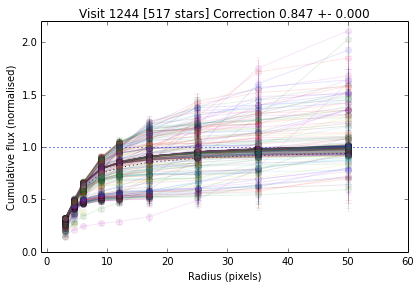

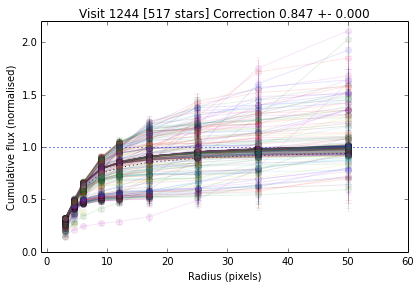

In [31]:
import lsst.meas.algorithms.measureCurveOfGrowth; lsst.meas.algorithms.measureCurveOfGrowth.fig = None
reload(lsst.meas.algorithms.measureCurveOfGrowth); CurveOfGrowth = lsst.meas.algorithms.measureCurveOfGrowth.CurveOfGrowth

ncog = CurveOfGrowth(fracInterpolatedMax=0.1, nAperture=9)
if False:
    nProf = len(allProfs)
    ids = [p.source.getId() for p in allProfs]
    
    if False:
        for s in [p.source for p, ccd in
                      zip(allProfs, splitId(ids)["ccd"]) if ccd >= 5 and ccd < 50]:
            pass
    for p in allProfs:
        ncog.addSource(p.source)
    #print sorted(set(splitId([p.source.getId() for p in ncog.profs])['ccd']))
else:
    ncog.radii = cog.radii
    ncog.profs = cog.profs + cog.badProfs

print len(ncog.profs), len(cog.profs), len(cog.badProfs)

ncog.estimate([10000, 1000], 500, 200)

rat, ratErr = ncog.getRatio(4, -1)
fig = ncog.plot(alpha=0.1, title="Visit %d [%d stars] Correction %.3f +- %.3f" % 
                (visit, len(ncog.profs), rat, ratErr))

fig.axes[0].set_xlim(-1, None)
_ = fig.axes[0].set_ylim(0., 2.2)

display(fig)

In [39]:
cog.curveOfGrowthCandidateKey = None
cog.curveOfGrowthUsedKey = None
for p in cog.profs:
    if p.source:
        p.psfFlux = p.source.getPsfFlux()
        p.psfFluxErr = p.source.getPsfFluxErr()
        p.id = p.source.getId()
    del p.source

#print cog.profs[10].source
cPickle.dump(cog, open("pickle-%d.pickle" % (visit), "w"))

PicklingError: Can't pickle <class 'lsst.meas.algorithms.measureCurveOfGrowth.CurveOfGrowth'>: it's not the same object as lsst.meas.algorithms.measureCurveOfGrowth.CurveOfGrowth

In [36]:
%debug

> /tigress/HSC/products/Linux64/python/2.7.6/lib/python2.7/copy_reg.py(70)_reduce_ex()
     69         if base is self.__class__:
---> 70             raise TypeError, "can't pickle %s objects" % base.__name__
     71         state = base(self)

ipdb> p base
<type 'SwigPyObject'>
ipdb> up
> <ipython-input-35-5ab1f17d6952>(11)<module>()
      9 
     10 import cPickle
---> 11 cPickle.dump(cog, open("pickle-%d.pickle" % (visit), "w"))

ipdb> down
> /tigress/HSC/products/Linux64/python/2.7.6/lib/python2.7/copy_reg.py(70)_reduce_ex()
     69         if base is self.__class__:
---> 70             raise TypeError, "can't pickle %s objects" % base.__name__
     71         state = base(self)

ipdb> l
     65         base = object # not really reachable
     66     if base is object:
     67         state = None
     68     else:
     69         if base is self.__class__:
---> 70             raise TypeError, "can't pickle %s objects" % base.__name__
     71         state = base(self)
     72    

AttributeError: 'NoneType' object has no attribute 'set_completer_delims'

In [ ]:
from lsst.meas.algorithms.measureCurveOfGrowth import CurveOfGrowth
import lsst.meas.algorithms.measureCurveOfGrowth; lsst.meas.algorithms.measureCurveOfGrowth.fig = None
reload(lsst.meas.algorithms.measureCurveOfGrowth); CurveOfGrowth = lsst.meas.algorithms.measureCurveOfGrowth.CurveOfGrowth

sch = cat.getSchema()
usedKey = sch.find("cmodel.flags.noCalib").getKey()
cog = CurveOfGrowth(curveOfGrowthUsedKey=usedKey, 
                    #fracInterpolatedMax=0.25, nAperture=8, skyNoiseFloor=0.5
                   )
for src in cat[cat.get('curveOfGrowth.candidate')]:
    if (1 or src.get('curveOfGrowth.used')) and src.get("flux.aperture")[6] > 1e4: # src.getPsfFlux() > 1e5:
        cog.addSource(src)
    else:
        src.set(usedKey, False)

if True:
    cog.estimate([4000, 1000, 500, 100, 50])

    fig = cog.plot(True, showRadialProfile=False, alpha=0.5, minLabelledValue=-1.00)
    fig.axes[0].set_xlim(-1, None)
    fig.axes[0].set_ylim(0.5, 1.1)

#fig.axes[0].set_xlim(0, 15)
#fig.axes[0].set_ylim(0.9, 1.1)

if False:
    with ds9.Buffering():
        ds9.erase(frame=frame)
        for src in cat[cat.get('curveOfGrowth.candidate')]:
            ds9.dot('o', *src.getCentroid(), ctype=ds9.GREEN if src.get(usedKey) else ds9.RED,
                    size=50, frame=frame)
            ds9.dot(str(src.getId() & 0xffff), *src.getCentroid(), frame=frame)
            if (src.getId() & 0xffff) == -122:
                ds9.pan(*src.getCentroid(), frame=frame)

In [ ]:
i = np.array([1070494828724249])

print splitId(i)

In [ ]:
ds9.show()